## **EDA**

**Data Loading**

In [2]:
#Load necessary libraries
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import zipfile
import os

# # Define the paths to the zip files
# train_zip_path = '/content/drive/MyDrive/Dogs_and_cats/train.zip'
test_zip_path = '/content/drive/MyDrive/Dogs_and_cats/test1.zip'

# # Unzipping train.zip
# with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/Dogs_and_cats/train')

# Unzipping test.zip
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/test')

# # Verify extraction
# print("Train folder contents:", os.listdir('/content/drive/MyDrive/Dogs_and_cats/train'))
print("Test folder contents:", os.listdir('/content/drive/MyDrive/test'))


Test folder contents: ['test1']


In [28]:
train_dir = '/content/drive/MyDrive/Dogs_and_cats/train/train'
test_dir = '/content/drive/MyDrive/test'


**Data Understanding**

Inspect Dataset Structure

In [ ]:
import os


filenames = os.listdir(train_dir)
categories = set([filename.split('.')[0] for filename in filenames])

# Print the unique categories
print(f"Unique categories: {categories}")


Unique categories: {'cat', 'dog'}


The number of Cat and Dogs images

In [ ]:
import os

# Initialize counters
dog_count = 0
cat_count = 0

# Loop through the filenames in the train directory
for filename in os.listdir(train_dir):
    if filename.startswith('dog'):
        dog_count += 1
    elif filename.startswith('cat'):
        cat_count += 1

# Print the distribution of images
print(f"Number of dog images: {dog_count}")
print(f"Number of cat images: {cat_count}")


Number of dog images: 12500
Number of cat images: 12500


Check the Shape and Size of Images

In [ ]:
import os
import cv2
import random


# Get all cat and dog images
cat_images = [f for f in os.listdir(train_dir) if f.startswith('cat')]
dog_images = [f for f in os.listdir(train_dir) if f.startswith('dog')]

# Randomly sample 3 cat images and 3 dog images
random_cat_images = random.sample(cat_images, 3)
random_dog_images = random.sample(dog_images, 3)

# Function to print image details
def check_image_size(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        height, width, channels = image.shape
        print(f"{os.path.basename(image_path)} - Height: {height}, Width: {width}, Channels: {channels}")
    else:
        print(f"Failed to load image: {image_path}")

# Check size of random cat images
print("Random Cat Images:")
for img in random_cat_images:
    check_image_size(os.path.join(train_dir, img))

# Check size of random dog images
print("\nRandom Dog Images:")
for img in random_dog_images:
    check_image_size(os.path.join(train_dir, img))


Random Cat Images:
cat.2040.jpg - Height: 329, Width: 499, Channels: 3
cat.6133.jpg - Height: 454, Width: 500, Channels: 3
cat.7649.jpg - Height: 381, Width: 499, Channels: 3

Random Dog Images:
dog.11636.jpg - Height: 499, Width: 395, Channels: 3
dog.6498.jpg - Height: 500, Width: 483, Channels: 3
dog.3126.jpg - Height: 499, Width: 491, Channels: 3


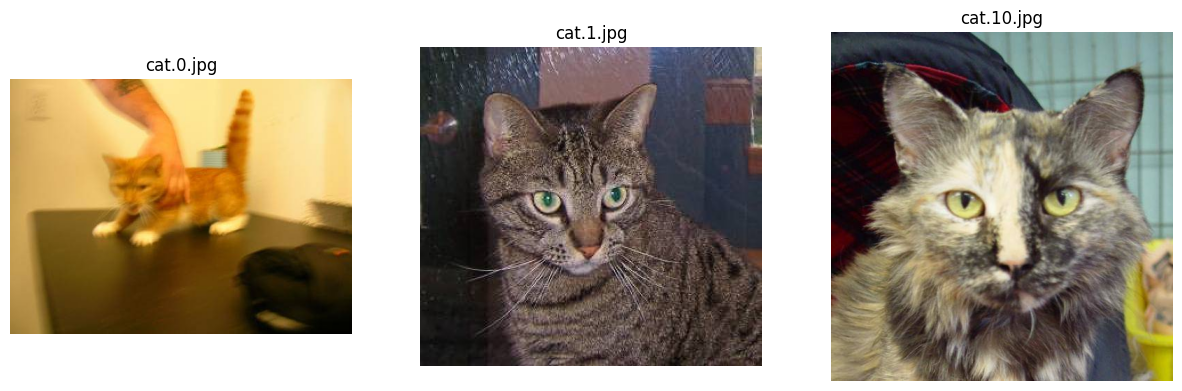

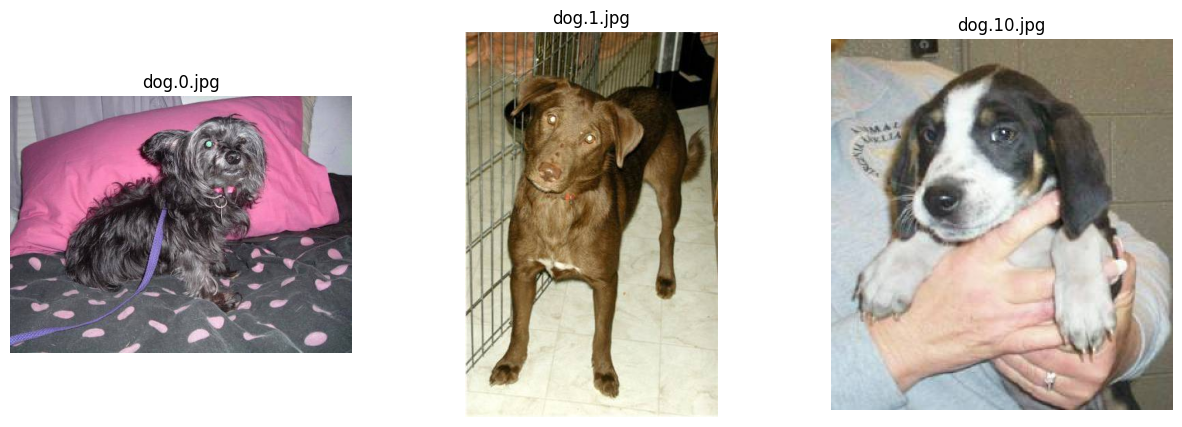

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2



def show_sample_images(directory, animal_type, num_samples=3):

    sample_images = [f for f in os.listdir(directory) if f.startswith(animal_type)]


    sample_images = sample_images[:num_samples]

    # Plotting the images
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')

    plt.show()

# Show sample images of cats and dogs
show_sample_images(train_dir, 'cat', num_samples=3)
show_sample_images(train_dir, 'dog', num_samples=3)


# Preprocessing

In [3]:
import os
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def load_images_with_labels(folder, img_size=(32, 32)):
    images = []
    labels = []

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)

        # Assign label based on filename
        if filename.lower().startswith("cat"):
            label = 0  # Label for cats
        elif filename.lower().startswith("dog"):
            label = 1  # Label for dogs
        else:
            continue

        # Open, resize, keep RGB, normalize
        img = Image.open(img_path).resize(img_size)
        img_array = np.array(img).flatten()/ 255.0  # Flatten RGB and normalize
        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels)




In [4]:
# Load images and labels
X, y = load_images_with_labels(train_dir)


In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import gc
from sklearn.pipeline import Pipeline
from sklearn.decomposition import IncrementalPCA



In [7]:

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # (num_samples, num_features)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  # (num_samples, num_features)


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_test_reshaped)


In [30]:
import gc
gc.collect()

23

In [9]:
# Scale and train as usual
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_val_scaled)

In [10]:
# Confirm reshaped dimensions
print("Shape after reshaping X_train:", X_train_reshaped.shape)
print("Shape after reshaping X_test:", X_test_reshaped.shape)
# Confirm scaled dimensions
print("Shape after scaling X_train:", X_train_scaled.shape)
print("Shape after scaling X_test:", X_test_scaled.shape)

Shape after reshaping X_train: (20000, 3072)
Shape after reshaping X_test: (5000, 3072)
Shape after scaling X_train: (20000, 3072)
Shape after scaling X_test: (5000, 3072)


# SVM Model

In [11]:
from sklearn.svm import SVC

pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)



In [12]:
print("Shape after scaling X_test:", X_test_pca.shape)

Shape after scaling X_test: (5000, 126)


In [13]:
# Create and train the SVM classifier
svm_classifier = SVC(kernel='rbf')



In [14]:
svm_classifier.fit(X_train_pca, y_train)


SVC()

In [15]:
y_pred = svm_classifier.predict(X_test_pca)

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

# Print confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

         Cat       0.68      0.67      0.68      2500
         Dog       0.68      0.68      0.68      2500

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000

Confusion Matrix:
[[1687  813]
 [ 811 1689]]


Cross Validation

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score

# Perform cross-validation on the training data
cv_scores = cross_val_score(svm_classifier, X_train_pca, y_train, cv=5)  # 5-fold cross-validation


print("Cross-validation scores for each fold:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
print("Standard deviation of cross-validation scores:", np.std(cv_scores))

# # Fit the model on the entire training set
# svm_classifier.fit(X_train_pca, y_train)

# # Predictions and evaluation on the test set
# y_pred = svm_classifier.predict(X_test_pca)

# # Print classification report and confusion matrix
# print('Classification Report:')
# print(classification_report(y_test, y_pred))
# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))

Cross-validation scores for each fold: [0.67625 0.667   0.67025 0.6655  0.67025]
Mean cross-validation score: 0.6698500000000001
Standard deviation of cross-validation scores: 0.0036966200778549103


Test File and save to CSV

In [23]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from PIL import Image

# Preprocess function for a single image
def preprocess_image(image_path, img_size=(32, 32)):
    img = Image.open(image_path).resize(img_size)
    img_flat = np.array(img).flatten() / 255.0  # Normalize and flatten
    return img_flat

# Natural sorting key function
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# Load and preprocess test images
def load_test_images(test_dir):
    test_images = []
    image_ids = []

    # List files and sort them in natural order
    for filename in sorted(os.listdir(test_dir), key=natural_sort_key):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(test_dir, filename)
            image_ids.append(filename)  # Store image ID
            test_images.append(preprocess_image(image_path))

    return np.array(test_images), image_ids

# Replace with your test directory path
X_test1, image_ids = load_test_images(test_dir)

# Scaling and PCA
X_test1_scaled = scaler.transform(X_test1)
X_test1_pca = pca.transform(X_test1_scaled)




In [24]:

y1_pred = svm_classifier.predict(X_test1_pca)

print(f"Training PCA shape: {X_train_pca.shape}")
print(f"Test PCA shape: {X_test1_pca.shape}")


Training PCA shape: (20000, 126)
Test PCA shape: (12500, 126)


In [25]:

# Prepare results for CSV
results = pd.DataFrame({
    'id': image_ids,
    'label': y1_pred
})

# Save results to a CSV file
results.to_csv('predictions.csv', index=False)
print("Predictions exported to 'predictions.csv'")

Predictions exported to 'predictions.csv'


In [26]:

import pandas as pd
from google.colab import files


# Prompt the user to download the file
files.download('predictions.csv')

print("Predictions exported to 'predictions.csv' and ready for download.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions exported to 'predictions.csv' and ready for download.


# CNN Model

Preprocessing

In [3]:
import os
import pandas as pd


# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Loop through each file in the folder
for filename in os.listdir(train_dir):
    # Check if the filename starts with "cat" or "dog" and label accordingly
    if filename.lower().startswith("cat"):
        labels.append(0)  # Label cats as 0
    elif filename.lower().startswith("dog"):
        labels.append(1)  # Label dogs as 1
    else:
        continue  # Skip files that don't match the pattern

    # Save the full path to the file
    file_paths.append(os.path.join(train_dir, filename))

# Create a DataFrame from the file paths and labels
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Display the first few rows of the DataFrame
print(df.head())


                                           file_path  label
0  /content/drive/MyDrive/Dogs_and_cats/train/tra...      1
1  /content/drive/MyDrive/Dogs_and_cats/train/tra...      1
2  /content/drive/MyDrive/Dogs_and_cats/train/tra...      1
3  /content/drive/MyDrive/Dogs_and_cats/train/tra...      1
4  /content/drive/MyDrive/Dogs_and_cats/train/tra...      1


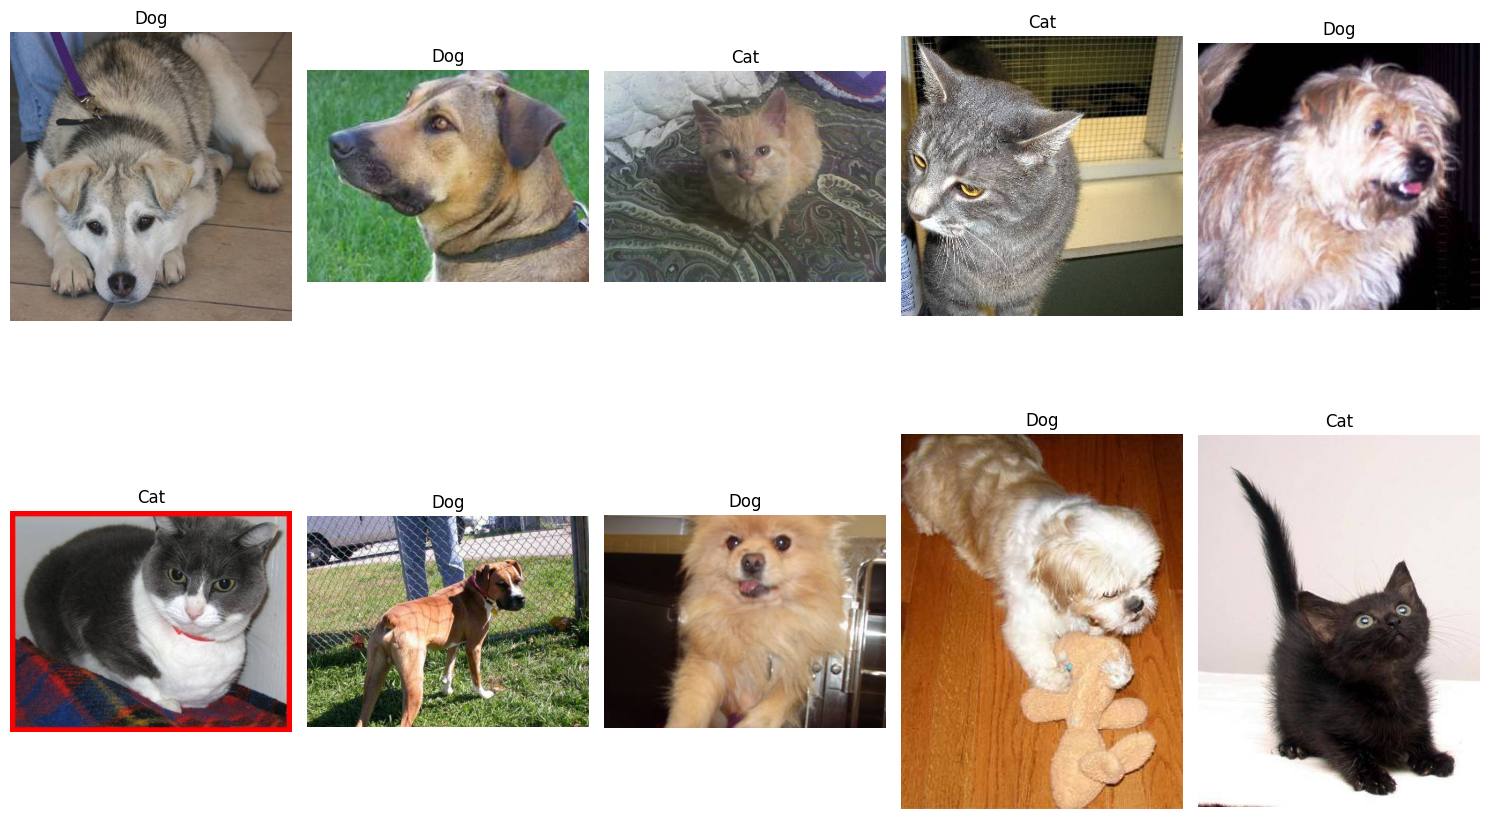

In [4]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Sample 10 random images from the DataFrame
sampled_df = df.sample(10).reset_index(drop=True)

# Set up the plot
plt.figure(figsize=(15, 10))

# Display each image
for i, row in sampled_df.iterrows():
    img_path = row['file_path']
    label = row['label']

    # Open and display the image
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Cat" if label == 0 else "Dog")

plt.tight_layout()
plt.show()


Spiliting

In [5]:
from sklearn.model_selection import train_test_split

# Define the paths and labels from the DataFrame
X = df['file_path'].values  # Image file paths
y = df['label'].values      # Labels (0 for cat, 1 for dog)

# Split data into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the split results
print("Number of training samples:", len(X_train))
print("Number of validation samples:", len(X_val))


Number of training samples: 20000
Number of validation samples: 5000


Data Augmentation

In [6]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import ResNet50, MobileNet, VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [7]:
# Convert labels to strings
y_train_str = y_train.astype(str)
y_val_str = y_val.astype(str)




In [8]:

# Define the image size and batch size
image_size = (96, 96)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          # Normalize pixel values to [0, 1]
             # Rotate images up to 20 degrees
    width_shift_range=0.2,      # Shift images horizontally up to 20% of width
    height_shift_range=0.2,     # Shift images vertically up to 20% of height
    shear_range=0.2,            # Shear transformations
    zoom_range=0.2,             # Zoom in and out by up to 20%
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill in pixels after transformation
)

In [9]:
# Create an ImageDataGenerator for validation (only rescaling)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)


# Prepare the training generator with updated labels
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train_str}),
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Binary classification expects string labels
)

# Prepare the validation generator with updated labels
val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val, 'class': y_val_str}),
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the CNN model
def create_model(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Dropout layer for regularization
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [11]:
# Instantiate the model
model = create_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define checkpoint and early stopping based on validation loss
checkpoint = ModelCheckpoint(
    "best_model_val_loss.keras",  # Change file extension to .keras
    monitor="val_loss",           # Monitor validation loss
    save_best_only=True,          # Save only the best model
    mode="min",                   # Minimize the validation loss
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,            # Stop if no improvement for 5 epochs
    mode="min",
    verbose=1
)

# Add these callbacks to your model's fit function
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5539 - loss: 0.6805
Epoch 1: val_loss improved from inf to 0.65635, saving model to best_model_val_loss.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 604s 262ms/step - accuracy: 0.5541 - loss: 0.6804 - val_accuracy: 0.5992 - val_loss: 0.6564
Epoch 2/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6493 - loss: 0.6260
Epoch 2: val_loss improved from 0.65635 to 0.51717, saving model to best_model_val_loss.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 256ms/step - accuracy: 0.6494 - loss: 0.6259 - val_accuracy: 0.7428 - val_loss: 0.5172
Epoch 3/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7167 - loss: 0.5531
Epoch 3: val_loss improved from 0.51717 to 0.48089, saving model to best_model_val_loss.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 256ms/step - accuracy: 0.7168 - loss: 0.5530 - val_accuracy: 0.7708 - val_loss: 0.4809
Epoch 4/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7457 - loss: 0.5143
Epoch 4: val_loss 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the test data generator without augmentation (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Configure the generator to read from the test directory
test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/test',   # Replace with the actual path
    target_size=(96, 96),            # Resize all images to match the model input
    batch_size=32,                     # Set batch size, adjust if needed
    class_mode=None,                   # No labels for test data
    shuffle=False                      # Don't shuffle so predictions match filenames
)


Found 12500 images belonging to 1 classes.


In [4]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("best_model_val_loss.keras")

# # Predict categories for all test images
# predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)


In [5]:
# # Convert predictions to category labels (0 or 1)
# predicted_classes = np.argmax(predictions, axis=1)

# Get list of filenames from the test generator
filenames = test_generator.filenames


In [6]:
filenames

['test1/1.jpg',
 'test1/10.jpg',
 'test1/100.jpg',
 'test1/1000.jpg',
 'test1/10000.jpg',
 'test1/10001.jpg',
 'test1/10002.jpg',
 'test1/10003.jpg',
 'test1/10004.jpg',
 'test1/10005.jpg',
 'test1/10006.jpg',
 'test1/10007.jpg',
 'test1/10008.jpg',
 'test1/10009.jpg',
 'test1/1001.jpg',
 'test1/10010.jpg',
 'test1/10011.jpg',
 'test1/10012.jpg',
 'test1/10013.jpg',
 'test1/10014.jpg',
 'test1/10015.jpg',
 'test1/10016.jpg',
 'test1/10017.jpg',
 'test1/10018.jpg',
 'test1/10019.jpg',
 'test1/1002.jpg',
 'test1/10020.jpg',
 'test1/10021.jpg',
 'test1/10022.jpg',
 'test1/10023.jpg',
 'test1/10024.jpg',
 'test1/10025.jpg',
 'test1/10026.jpg',
 'test1/10027.jpg',
 'test1/10028.jpg',
 'test1/10029.jpg',
 'test1/1003.jpg',
 'test1/10030.jpg',
 'test1/10031.jpg',
 'test1/10032.jpg',
 'test1/10033.jpg',
 'test1/10034.jpg',
 'test1/10035.jpg',
 'test1/10036.jpg',
 'test1/10037.jpg',
 'test1/10038.jpg',
 'test1/10039.jpg',
 'test1/1004.jpg',
 'test1/10040.jpg',
 'test1/10041.jpg',
 'test1/10042.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Predict categories for all test images
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# # Convert predictions to binary classes (0 or 1)




/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 141ms/step


In [13]:
import pandas as pd
import os

predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Extract filenames from the test generator and remove directory path
filenames = [os.path.basename(filename) for filename in test_generator.filenames]

# Create a DataFrame with filenames and predicted classes
results = pd.DataFrame({
    "ID": filenames,
    "Label": predicted_classes
})

# Sort filenames by numeric order (assuming they follow this format)
results['NumericID'] = results['ID'].str.extract('(\d+)').astype(int)  # Extract numeric ID
results = results.sort_values('NumericID').drop(columns='NumericID')  # Sort by numeric ID and drop column



# Save results to a CSV file
results.to_csv("predictions1.csv", index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


In [14]:

import pandas as pd
from google.colab import files


# Prompt the user to download the file
files.download('predictions1.csv')

print("Predictions exported to 'predictions.csv' and ready for download.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions exported to 'predictions.csv' and ready for download.
